![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [31]:
# Import the libraries and modules to be used.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

In [32]:
# Read the file
rentals = pd.read_csv("rental_info.csv", parse_dates = ["rental_date", "return_date"])
rentals.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [33]:
# Check the infomations about dataframe
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64              
 9   PG                15861 non-null  int64              
 10  PG-13             15861 non-null  int64              
 11  R                 15861 non-null  int64              
 12  amount_2          15861 non-null  float64            
 13  l

In [34]:
# Inspect the categorical column
rentals["special_features"].astype("category").value_counts()

{Trailers,Commentaries,"Behind the Scenes"}                     1308
{Trailers}                                                      1139
{Trailers,Commentaries}                                         1129
{Trailers,"Behind the Scenes"}                                  1122
{"Behind the Scenes"}                                           1108
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{Commentaries}                                                  1089
{Commentaries,"Behind the Scenes"}                              1078
{Trailers,"Deleted Scenes"}                                     1047
{"Deleted Scenes","Behind the Scenes"}                          1035
{"Deleted Scenes"}                                              1023
{Commentaries,"Deleted Scenes"}                                 1011
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Trailers,Commentaries,"Deleted Scenes"}                         916
{Trailers,"Deleted Scenes","Behind

In [35]:
# Creating the target variable
rentals["rental_length_days"] = (rentals["return_date"] - rentals["rental_date"]).dt.days
# Create the dummy variables from special_features column
rentals["deleted_scenes"] = np.where(rentals["special_features"].str.contains("Deleted Scenes"), 1, 0)
rentals["behind_the_scenes"] = np.where(rentals["special_features"].str.contains("Behind the Scenes"), 1, 0)
# Drop columns which will not be used
columns = ["rental_date", "return_date", "special_features"]
rentals_df = rentals.drop(columns, axis = 1)
rentals_df["deleted_scenes"].value_counts()

0    7973
1    7888
Name: deleted_scenes, dtype: int64

In [36]:
# Creat dataframe of features and target variable
X = rentals_df.drop("rental_length_days", axis = 1)
y = rentals_df["rental_length_days"]
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9, stratify=y)

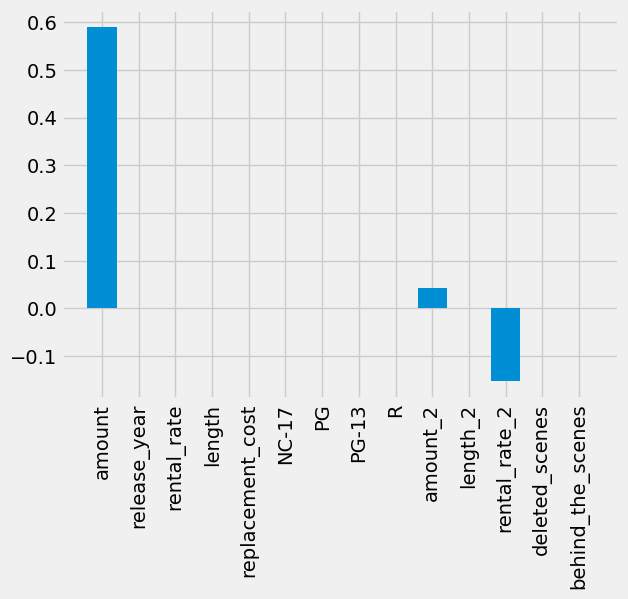

In [37]:
# Create Lasso regression to determine feature importances
lasso = Lasso(alpha=0.3, random_state=9)
# Fit the model
lasso.fit(X_train, y_train)
# Get the coefficients for features importance
feat_import = lasso.coef_
# Visualize the feature importance
plt.style.use('fivethirtyeight')
plt.bar(X.columns, feat_import)
plt.xticks(rotation = 90)
plt.show()

In [38]:
# Select the best features
X_train_best = X_train.iloc[:,feat_import > 0]
X_test_best = X_test.iloc[:,feat_import > 0]
# Instantiate Linear Regression model
lr = LinearRegression()
# Fit the model
lr.fit(X_train_best, y_train)
# Make predictions
y_pred = lr.predict(X_test_best)
# Measure performance
mse = mean_squared_error(y_pred, y_test)
mse

4.850746588920103

In [39]:
# Create random forest regressor
rf = RandomForestRegressor(random_state=9)
# Make parameters to search over
param_rf = {"n_estimators": np.arange(1, 101, 1),
           "max_depth": np.arange(1, 11, 1)}
# Instantiate 10-fold RandomizedSearch object
random_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_rf, cv = 5, random_state = 9)
# Fit the model
random_rf.fit(X_train, y_train)
# Get the best model
best_model_rf = random_rf.best_estimator_
# Make prediction 
y_pred_rf = best_model_rf.predict(X_test)
# Measure performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_rf

2.164534523406932

In [40]:
# Record the best model and it's score
best_model = rf
best_mse = mse_rf